### Import Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Load Dataset

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Danazzz/beras-scm/main/csv/Beras.csv")
df

,Tanggal,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Harga Beras Penggilingan,Produksi Beras,Harga Beras,UMP,BBM Solar,Tingkat Konsumsi
0,2021-03-15,10,4000,4150,5050,9465,14419,11200,4960,9600,17161
1,2021-03-16,10,3850,4100,4740,9360,14419,11200,4960,9600,17161
2,2021-03-17,10,4160,4230,4950,9400,14419,11200,4960,9600,17161
3,2021-03-18,10,4120,4190,4730,9340,14419,11200,4960,9600,17161
4,2021-03-19,10,4190,4290,4990,9410,14419,11200,4960,9600,17161
...,...,...,...,...,...,...,...,...,...,...,...
673,2023-12-21,30,6770,6850,7980,13100,14391,14000,5444,6800,17598
674,2023-12-22,30,6600,6760,8050,13095,14391,14000,5444,6800,17598
675,2023-12-27,30,6620,6760,8030,13120,14391,14000,5444,6800,17598
676,2023-12-28,30,6650,6760,8020,13120,14391,14000,5444,6800,17598


### Preprocessing

In [ ]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df['Year'] = df['Tanggal'].dt.year
df['Month'] = df['Tanggal'].dt.month

In [ ]:
data_mod = df.drop(columns=['Tanggal', 'GKP Tingkat Petani', 'GKP Tingkat Penggilingan'])

X = data_mod.drop('Harga Beras', axis=1)
y = data_mod['Harga Beras']

### Split Dataset

In [ ]:
cutoff_index = int(len(data_mod) * 0.8)

# Split the dataset into training and testing sets using the calculated index
X_train = X.iloc[:cutoff_index]
X_test = X.iloc[cutoff_index:]
y_train = y.iloc[:cutoff_index]
y_test = y.iloc[cutoff_index:]

### Model Training

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of gradient boosted trees
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage used to prevent overfitting
    'max_depth': [3, 5, 7]  # Maximum depth of a tree
}

# Initialize XGBRegressor
xgb = XGBRegressor(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best estimator and parameters
best_xgb = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

best_xgb, best_score, best_params

Fitting 5 folds for each of 27 candidates, totalling 135 fits


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 -82967.74924755114,
 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100})

Mean Squared Error: 1305668.8194862325
R-squared Score: -1.729369284512595


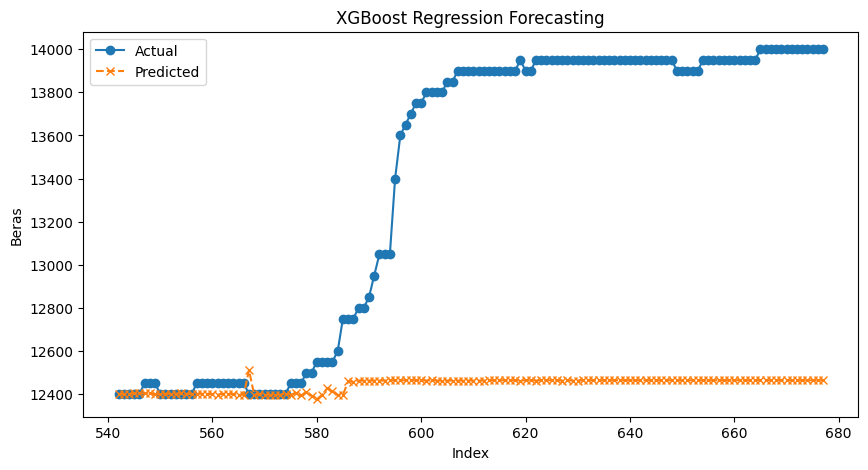

In [ ]:
# Make predictions on the testing data using the best XGBoost model
predictions = best_xgb.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print('Mean Squared Error:', mse)
print('R-squared Score:', r2)

# Optionally, visualize the actual and predicted values
plt.figure(figsize=(10, 5))
plt.plot(X_test.index, y_test, label='Actual', marker='o')
plt.plot(X_test.index, predictions, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Index')
plt.ylabel('Beras')
plt.title('XGBoost Regression Forecasting')
plt.legend()
plt.show()

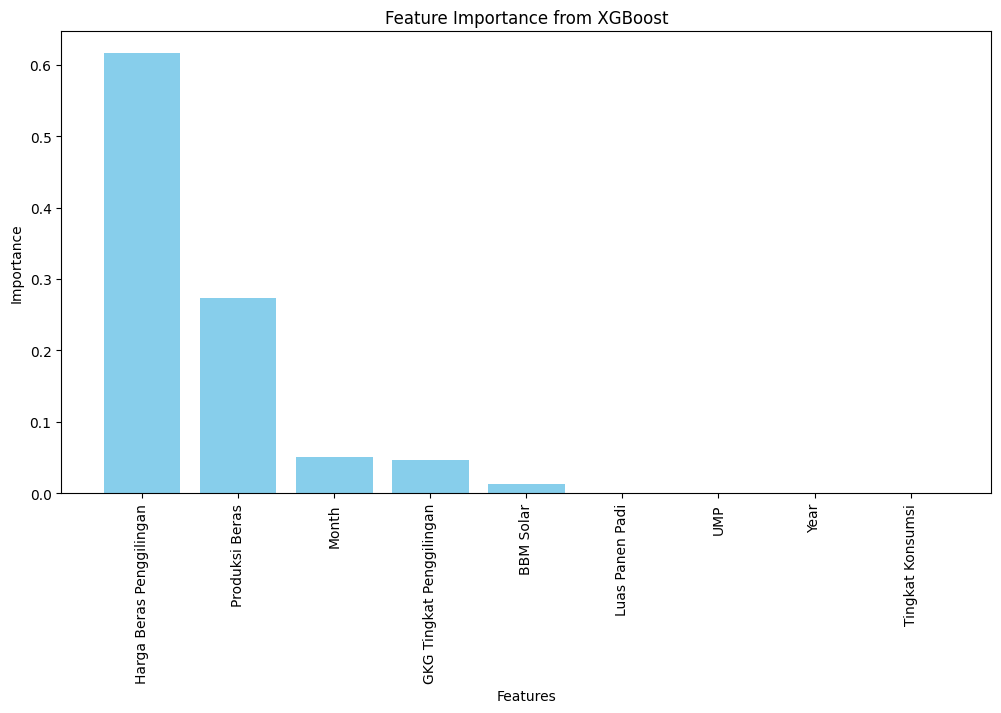

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the best XGBoost model
importances_xgb = best_xgb.feature_importances_
# Sort the feature importances in descending order and get the indices
indices_xgb = np.argsort(importances_xgb)[::-1]

# Create labels for the x-axis by using feature names sorted by importance
feature_labels_xgb = X_train.columns[indices_xgb]

# Create a bar plot of the feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(X_train.shape[1]), importances_xgb[indices_xgb], align='center', color='skyblue')
plt.xticks(range(X_train.shape[1]), feature_labels_xgb, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from XGBoost')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(df[-len(predictions):]["Harga Beras"], predictions))
mae = mean_absolute_error(df[-len(predictions):]["Harga Beras"], predictions)
print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

# R Square
r = r2_score(df[-len(predictions):]["Harga Beras"], predictions)

# Mean Square Error
mse = mean_squared_error(df[-len(predictions):]["Harga Beras"], predictions)

# Menampilkan hasil
print("R Square: {:.4f}".format(r))
print("Mean Square Error:", mse)

Root Mean Square Error: 1142.6586627187633
Mean Absolute Error: 930.9099336511948
R Square: -1.7294
Mean Square Error: 1305668.8194862325
